# Noise2Self on Neural Nets

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks.

For didactic purposes, we use a simple dataset (Gaussian noise on MNIST), a simple model (a small UNet), and a short training (100 iterations on a CPU). This notebook runs on a MacBook Pro in under one minute.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('../data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                    ]), train = False)

In [5]:
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.4

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [6]:
noisy_mnist_train = SyntheticNoiseDataset(mnist_train, 'train')
noisy_mnist_test = SyntheticNoiseDataset(mnist_test, 'test')

We will try to learn to predict the clean image on the right from the noisy image on the left.

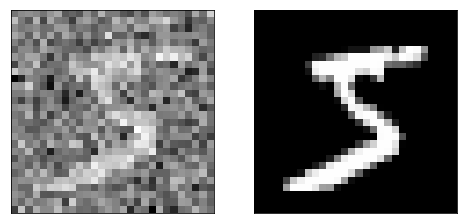

In [7]:
noisy, clean = noisy_mnist_train[0]
plot_images([noisy[0].numpy(), clean[0].numpy()])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [8]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

In [9]:
net_input, mask = masker.mask(noisy.unsqueeze(0), 0)

A mask; the data; the input to the neural net, which doesn't depend on the values of $x$ inside the mask; and the difference between the neural net input and $x$.

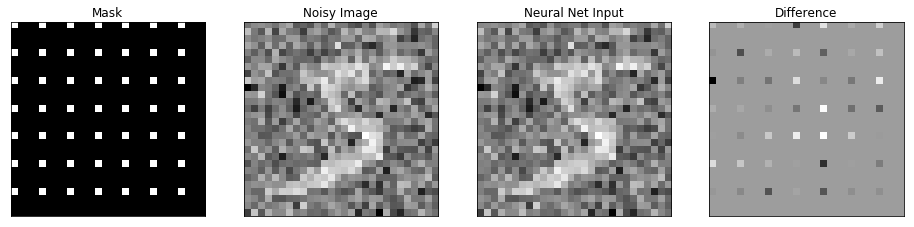

In [10]:
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [11]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:
data_loader = DataLoader(noisy_mnist_train, batch_size=32, shuffle=True)

for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch
    
    net_input, mask = masker.mask(noisy_images, i)
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy_images*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        print("Loss (", i, "): ", loss.item())
        
    if i == 100:
        break

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss ( 0 ):  0.15816202759742737
Loss ( 10 ):  0.0345885306596756
Loss ( 20 ):  0.0133558614179492
Loss ( 30 ):  0.011575892567634583
Loss ( 40 ):  0.011927726678550243
Loss ( 50 ):  0.011372310109436512
Loss ( 60 ):  0.011778540909290314
Loss ( 70 ):  0.012034449726343155
Loss ( 80 ):  0.011101883836090565
Loss ( 90 ):  0.011414164677262306
Loss ( 100 ):  0.01207648403942585


In [14]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

With our trained model, we have a choice. We may do a full $J$-invariant reconstruction, or we may just run the noisy data through the network unaltered.

In [15]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

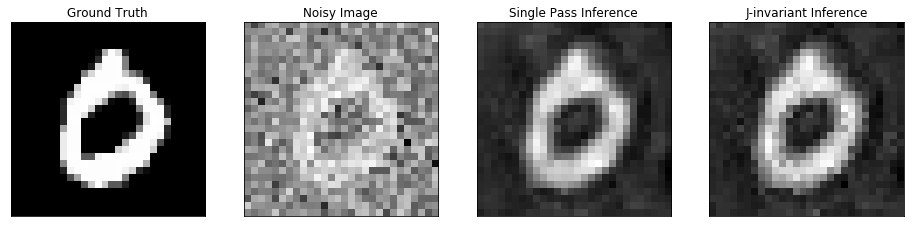

In [16]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-invariant Inference"])

In [17]:
print("Test loss, simple: ", round(loss_function(clean, simple_output).item(), 3))
print("Test loss, invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, simple:  0.018
Test loss, invariant:  0.021


While both the simple and invariant output are significantly denoised, the invariant output has a mild pixelation. 

This is due to the fact that neighboring pixels are denoised using different information, leading to discontinuities in the reconstructed output.